# Data Analytics 111-2 Homework #05
Alexander Nilsson

In [24]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

## 1. LASSO and ridge

In [45]:
import zipfile
with zipfile.ZipFile('ORL Faces.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Create an empty NumPy array to store the images and a gender column
#400 rows one for each picture, 2576 columns for the image, 1 for the gender
data_matrix = np.zeros((400, 2577))

# Get a list of all PNG files in the directory
files = glob.glob("ORL Faces/*.png")

# Loop through the image files and read them into the data matrix
for i, filename in enumerate(files):
    # Read the image using OpenCV
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    # Resize the image to 46x56
    img = cv2.resize(img, (56, 46))
    
    # Flatten the image into a 1D array and store it in the data matrix
    data_matrix[i, :-1] = img.flatten()
    
    # Check the filename to determine gender
    if filename.split("/")[-1].startswith(("1_", "8_", "10_", "32_")):
        data_matrix[i, -1] = 0
    else:
        data_matrix[i, -1] = 1

# Print the shape of the data matrix
print(data_matrix.shape)


### Select the lambda associated with the minimal MSE fit and compare the results with that of your stepwise regression in HW02

In [47]:
X = data_matrix[:, :-1]
y = data_matrix[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tried this approach 

find the optimal lambda value for LASSO and Ridge regressions using cross-validation using: 

```
lasso_cv = LassoCV(cv=5).fit(X_train, y_train)
ridge_cv = RidgeCV(cv=5).fit(X_train, y_train)

best_lambda_lasso = lasso_cv.alpha_
best_lambda_ridge = ridge_cv.alpha_

print("Best lambda for LASSO:", best_lambda_lasso)
print("Best lambda for Ridge:", best_lambda_ridge)
```

got this error: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#lasso_cv = LassoCV(cv=5).fit(X_train_scaled, y_train)
#ridge_cv = RidgeCV(cv=5).fit(X_train_scaled, y_train)

# create LassoCV and RidgeCV models with increased max_iter and decreased tol
lasso_cv = LassoCV(cv=10, max_iter=10000, tol=0.001).fit(X_train_scaled, y_train)
ridge_cv = RidgeCV(cv=10).fit(X_train_scaled, y_train)

best_lambda_lasso = lasso_cv.alpha_
best_lambda_ridge = ridge_cv.alpha_

C:\Users\Aleni\miniconda3\envs\gpu_notebook\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Aleni\miniconda3\envs\gpu_notebook\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Aleni\miniconda3\envs\gpu_notebook\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

In [55]:
lasso = Lasso(alpha=best_lambda_lasso).fit(X_train, y_train)
ridge = Ridge(alpha=best_lambda_ridge).fit(X_train, y_train)

# Calculate the mean squared error for the LASSO and Ridge models
mse_lasso = mean_squared_error(y_test, lasso.predict(X_test))
mse_ridge = mean_squared_error(y_test, ridge.predict(X_test))

print("LASSO MSE:", mse_lasso)
print("Ridge MSE:", mse_ridge)

LASSO MSE: 0.0
Ridge MSE: 0.0


C:\Users\Aleni\miniconda3\envs\gpu_notebook\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


fit the LASSO and Ridge models with the best lambda values

### b) plot the chosen pixels from LASSO regression on a 46 × 56 canvas

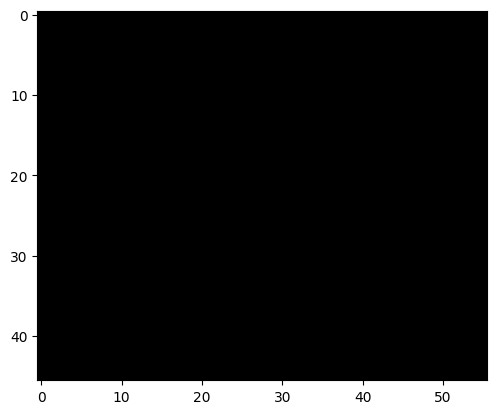

In [57]:
# Find the chosen pixels from the LASSO regression
chosen_pixels_lasso = np.where(lasso.coef_ != 0)[0]

# Create a blank 46 x 56 canvas
canvas_lasso = np.zeros((46, 56))

# Set the chosen significant pixels to 1 on the canvas
for pixel in chosen_pixels_lasso:
    x, y = divmod(pixel, 56)
    canvas_lasso[x, y] = 1

# Display the canvas with the chosen significant pixels
plt.imshow(canvas_lasso, cmap='gray')
plt.show()

despite trying a few different ways I never made my solutions converge, I'm not sure if this is becouse the lasso algorithm cant handle this problem or becouse I am implementing it the wrong way.

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

## 2. Federal Reserve Bank

To solve this problem, we first need to convert the given model into a linear form by taking the logarithm of both sides. Then, we can use ordinary least squares (OLS) to estimate the parameters.

In [43]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

data = {'year': [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86],
        'capital': [1209188, 1330372, 1157371, 1070860, 1233475, 1355769, 1351667, 1326248, 1089545, 1111942, 988165, 1069651, 1191677, 1246536, 1281262],
        'labor': [1259142, 1371795, 1263084, 1118226, 1274345, 1369877, 1451595, 1328683, 1077207, 1056231, 947502, 1057159, 1169442, 1195255, 1171664],
        'value_added': [11150.0, 12853.6, 10450.8, 9318.3, 12097.7, 12844.8, 13309.9, 13402.3, 8571.0, 8739.7, 8140.0, 10958.4, 10838.9, 10030.5, 10836.5]}

df = pd.DataFrame(data)

                            OLS Regression Results                            
Dep. Variable:         ln_value_added   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     27.03
Date:                Sat, 01 Apr 2023   Prob (F-statistic):           3.59e-05
Time:                        13:31:54   Log-Likelihood:                 19.253
No. Observations:                  15   AIC:                            -32.51
Df Residuals:                      12   BIC:                            -30.38
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.6259      2.900     -3.320      0.0

C:\Users\Aleni\miniconda3\envs\gpu_notebook\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### a. Estimating β1 and β2 without constraint:
1. Convert the model into a linear form:
ln(V_t) = ln(α) + β1 * ln(K_t) + β2 * ln(L_t) + ln(η_t)

2. Run a linear regression with ln(V_t) as the dependent variable and ln(K_t) and ln(L_t) as independent variables.

In [ ]:
# Take the logarithm of the variables
df['ln_value_added'] = np.log(df['value_added'])
df['ln_capital'] = np.log(df['capital'])
df['ln_labor'] = np.log(df['labor'])

In [ ]:
X = df[['ln_capital', 'ln_labor']]
X = sm.add_constant(X)
y = df['ln_value_added']

model_a = sm.OLS(y, X).fit()
print(model_a.summary())

### b) Estimating β1 and β2 with the constraint β1 + β2 = 1:

Run a linear regression with ln(V_t) - ln(L_t) as the dependent variable and ln(K_t) - ln(L_t) as the independent variable. This will give an estimate of β1, and β2 can then be calculated as 1 - β1.

In [44]:
df['ln_V_over_L'] = df['ln_value_added'] - df['ln_labor']
df['ln_K_over_L'] = df['ln_capital'] - df['ln_labor']

X_b = sm.add_constant(df['ln_K_over_L'])
y_b = df['ln_V_over_L']

model_b = sm.OLS(y_b, X_b).fit()
print(model_b.summary())

beta1_b = model_b.params['ln_K_over_L']
beta2_b = 1 - beta1_b
print(f"Constrained β1: {beta1_b}, β2: {beta2_b}")

                            OLS Regression Results                            
Dep. Variable:            ln_V_over_L   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                 0.0004737
Date:                Sat, 01 Apr 2023   Prob (F-statistic):              0.983
Time:                        13:31:57   Log-Likelihood:                 17.644
No. Observations:                  15   AIC:                            -31.29
Df Residuals:                      13   BIC:                            -29.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.7129      0.021   -227.090      

C:\Users\Aleni\miniconda3\envs\gpu_notebook\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## 3. Implement a PCA function 

### a) pca and scree_plot - functions 

In [6]:
def standardize(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [28]:
def pca(X, isCorrMX):
    X_standardized = standardize(X)

    if isCorrMX:
        matrix = np.corrcoef(X_standardized.T)
    else:
        matrix = np.cov(X_standardized.T)

    eigenvalues, eigenvectors = np.linalg.eig(matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    sorted_eigenvalues = eigenvalues[sorted_indices]

    score_matrix = np.dot(X_standardized, sorted_eigenvectors)
    cumulative_variance_explained = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)

    return sorted_eigenvectors, sorted_eigenvalues, score_matrix, cumulative_variance_explained

In [8]:
def scree_plot(eigenvalues, cumulative_variance_explained):
    plt.figure()
    plt.bar(range(1, len(eigenvalues) + 1), eigenvalues)
    plt.plot(range(1, len(eigenvalues) + 1), cumulative_variance_explained, marker='o', color='r')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Explained')
    plt.title('Scree Plot')
    plt.show()

### b) auto-mpg

Load AutoMPG dataset and preprocess it

In [59]:
import pandas as pd

# define the column names
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'name']

# read the data from the text file
df = pd.read_csv('auto-mpg.data.txt', delim_whitespace=True, names=columns, na_values='?')

# print the first few rows of the DataFrame
print(df.head())

df.drop('name', axis=1, inplace=True)
df.dropna(inplace=True)

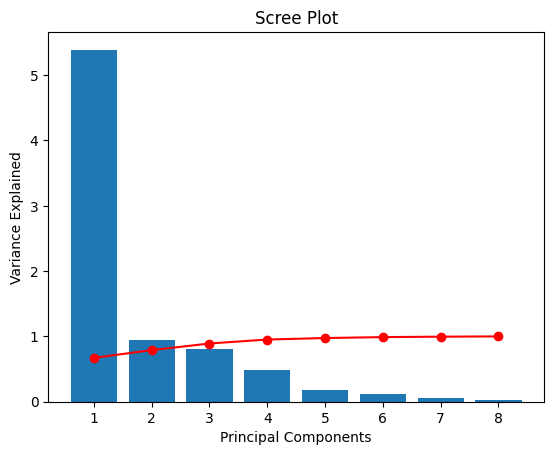

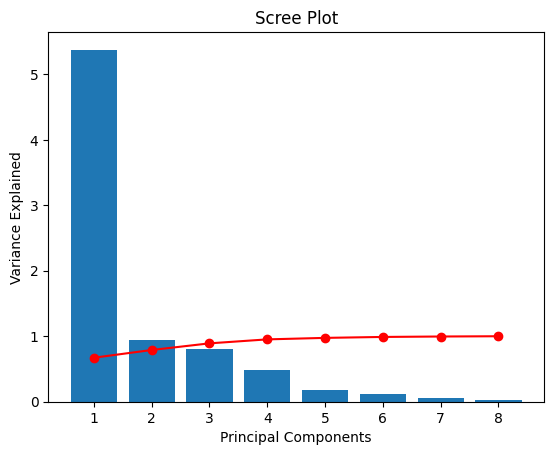

In [19]:
X = df

loadings_cov, eigenvalues_cov, scores_cov, cum_var_cov = pca(X, isCorrMX=False)
loadings_corr, eigenvalues_corr, scores_corr, cum_var_corr = pca(X, isCorrMX=True)

scree_plot(eigenvalues_cov, cum_var_cov)
scree_plot(eigenvalues_corr, cum_var_corr)

These scree plots are very similar for both the cases (isCorrMX=True and isCorrMX=False), it suggests that PCA is not sensitive to the scale of the features in this particular dataset. 

However, this observation is specific to the Auto MPG dataset and might not be generalizable to other datasets. In general, PCA is not scale-invariant.

## 4. PCA ORL face dataset

In [37]:
# Transpose the ORL face dataset
X = data_matrix[:, :-1].T

# Perform PCA
eigenvectors, eigenvalues, score_matrix, cumulative_variance_explained = pca(X, isCorrMX=True)

def num_components_for_variance(cumulative_variance_explained, target_variance):
    return np.argmax(cumulative_variance_explained >= target_variance) + 1

percentages = [0.5, 0.6, 0.7, 0.8, 0.9]
num_components = [num_components_for_variance(cumulative_variance_explained, p) for p in percentages]

for p, n in zip(percentages, num_components):
    print(f"Number of principal components for {p*100}% variance: {n}")


Number of principal components for 50.0% variance: 2
Number of principal components for 60.0% variance: 3
Number of principal components for 70.0% variance: 6
Number of principal components for 80.0% variance: 13
Number of principal components for 90.0% variance: 38


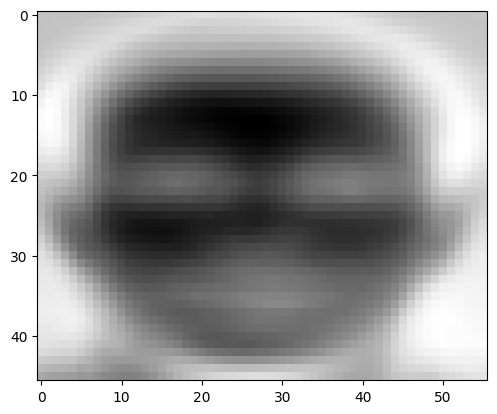

In [38]:
# Get the first principal component scores
first_pc_scores = score_matrix[:, 0]

# Reshape the first principal component scores into a 46x56 matrix
reshaped_pc_scores = np.reshape(first_pc_scores, (46, 56))

# Rescale the reshaped first principal component scores
rescaled_pc_scores = (reshaped_pc_scores - np.min(reshaped_pc_scores)) / (np.max(reshaped_pc_scores) - np.min(reshaped_pc_scores)) * 255

# Plot the image
plt.imshow(rescaled_pc_scores, cmap="gray")
plt.show()
